In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from tqdm import tqdm
from warnings import filterwarnings
import pickle
import os
import shutil
import random
import cv2

In [4]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay

In [5]:
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import plot_model

In [6]:
filterwarnings("ignore")
np.random.seed(0)

In [7]:
import os
train_img = []
train_labels_not_encoded = []

test_img = []
test_labels_not_encoded = []

path_train = ('/Users/jaint/OneDrive/Desktop/brain tumor detection/brain-tumor-classification-mri/Training/')
path_test = ('/Users/jaint/OneDrive/Desktop/brain tumor detection/brain-tumor-classification-mri/Testing/')

img_size= 160
for i in os.listdir(path_train):
    for j in tqdm(os.listdir(path_train+i)):
        train_img.append(cv2.resize(cv2.imread(path_train+i+'/'+j), (img_size,img_size))) 
        train_labels_not_encoded.append(i)
for i in os.listdir(path_test):
    for j in tqdm(os.listdir(path_test+i)):
        test_img.append(cv2.resize(cv2.imread(path_test+i+'/'+j), (img_size,img_size))) 
        test_labels_not_encoded.append(i)
        
train_img = np.array(train_img)
test_img = np.array(test_img)

100%|█████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 155.04it/s]


In [8]:
y_train = pd.get_dummies(train_labels_not_encoded)
y_test = pd.get_dummies(test_labels_not_encoded)
labels=y_train.columns

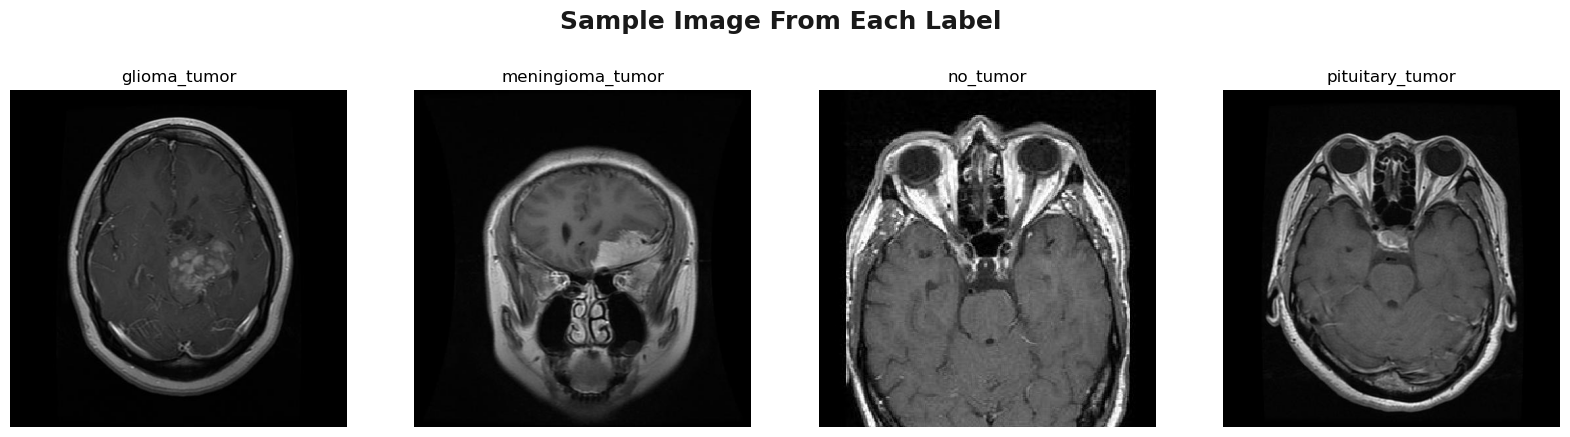

In [9]:
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
         color="black",y=0.61,x=0.4,alpha=0.9)
for count, ele in enumerate(os.listdir(path_train)):
    for j in os.listdir(path_train+ele):
        img= cv2.imread(path_train+ele+'/'+j)
        ax[count].imshow(img)
        ax[count].set_title(ele)
        ax[count].axis('off')
        break

In [10]:
print("Train size:", train_img.shape[0], "Test size:", test_img.shape[0])

Train size: 2870 Test size: 394


In [11]:
y_train

,glioma_tumor,meningioma_tumor,no_tumor,pituitary_tumor
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
2865,0,0,0,1
2866,0,0,0,1
2867,0,0,0,1
2868,0,0,0,1


In [12]:
train_img_gray = tf.image.rgb_to_grayscale(train_img)
test_img_gray = tf.image.rgb_to_grayscale(test_img)

In [13]:
def clear_previous_calculations():
    try: 
        shutil.rmtree("logs")
    except Exception as e:
        pass
    
    for i in ["tumor_model.h5", "predictions.pkl"]:
        try: 
            os.remove(i)
        except Exception as e:
            pass

In [14]:
def get_model():
    data_augmentation = Sequential([layers.RandomFlip("horizontal_and_vertical",input_shape=(img_size, img_size, 1)),
                                    layers.RandomRotation(0.1),
                                    layers.RandomZoom(0.1)])

    model = Sequential([data_augmentation,
                        layers.Rescaling(1./255, input_shape=(img_size, img_size, 1)),
                        layers.Conv2D(32, 3, padding='same', activation='relu'),
                        layers.BatchNormalization(),
                        layers.Conv2D(32, 3, padding='same', activation='relu'),
                        layers.BatchNormalization(),
                        layers.Conv2D(64, 3, padding='same', activation='relu'),
                        layers.AveragePooling2D(),
                        layers.Conv2D(128, 3, padding='same', activation='relu'),
                        layers.MaxPooling2D(),
                        layers.BatchNormalization(),
                        layers.Conv2D(246, 3, padding='same', activation='relu'),
                        layers.AveragePooling2D(),
                        layers.Conv2D(20, 3, padding='same', activation='relu'),
                        layers.BatchNormalization(),
                        layers.Flatten(),
                        layers.Dense(128, activation='relu'),
                        layers.Dense(4, activation='softmax')
                       ])
    return model

In [15]:
def get_callbacks():
    tensorboard = TensorBoard(log_dir = 'logs', histogram_freq=1)
    checkpoint = ModelCheckpoint("tumor_model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.6, patience = 5, min_delta = 0.0000001,
                                  mode='auto',verbose=1, min_lr=0.0000000000001)
    return [tensorboard,checkpoint,reduce_lr]

In [16]:
def get_fig_and_axes_list(plot_count,column_number=2):

    reminder_num = plot_count % column_number
    row_num = (plot_count // column_number) + (reminder_num > 0)
    axes_list = []
    row_number_alignment = np.ones((row_num, column_number), dtype="int")
    if reminder_num != 0:
        row_number_alignment[-1,-(column_number - reminder_num):] = 0
    coefficient = (3.5 if plot_count==1 else 4.2)
    col_size = coefficient*column_number
    row_size = coefficient*row_num
    fig = plt.figure(figsize=(col_size, row_size), layout="constrained")
    spec = fig.add_gridspec(row_num, column_number)
    for i in range(row_number_alignment.shape[0]):
        for j in range(row_number_alignment.shape[1]):
            if row_number_alignment[i,j] == 1:
                ax = fig.add_subplot(spec[i,j])
                axes_list.append(ax)
    return fig,axes_list

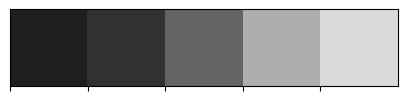

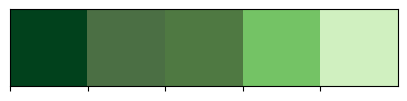

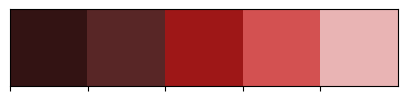

In [17]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [18]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) 
clear_previous_calculations()
model = get_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 160, 160, 1)       0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 160, 160, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 160, 160, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 160, 160, 32)     128       
 hNormalization)                                      

In [19]:
epochs = 50
batch_size=100
all_callbacks = get_callbacks()
history = model.fit(train_img_gray, y_train, validation_split=0.2,  epochs=epochs, batch_size=batch_size,
                    callbacks=all_callbacks,  shuffle=True, verbose=1, workers=1)
model.load_weights('tumor_model.h5')

Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: 1.4602 - accuracy: 0.5719
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to tumor_model.h5
23/23 [==============================] - 235s 10s/step - loss: 1.4602 - accuracy: 0.5719 - val_loss: 1.2155 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/50
23/23 [==============================] - ETA: 0s - loss: 0.7501 - accuracy: 0.6716
Epoch 2: val_accuracy improved from 0.00000 to 0.01568, saving model to tumor_model.h5
23/23 [==============================] - 221s 10s/step - loss: 0.7501 - accuracy: 0.6716 - val_loss: 1.2742 - val_accuracy: 0.0157 - lr: 0.0010
Epoch 3/50
23/23 [==============================] - ETA: 0s - loss: 0.6211 - accuracy: 0.7352
Epoch 3: val_accuracy did not improve from 0.01568
23/23 [==============================] - 216s 9s/step - loss: 0.6211 - accuracy: 0.7352 - val_loss: 2.5903 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/50
23/23 [==============================] - ETA: 

23/23 [==============================] - 212s 9s/step - loss: 0.0630 - accuracy: 0.9834 - val_loss: 0.7327 - val_accuracy: 0.7230 - lr: 1.2960e-04
Epoch 28/50
23/23 [==============================] - ETA: 0s - loss: 0.0667 - accuracy: 0.9813
Epoch 28: val_accuracy did not improve from 0.99303
23/23 [==============================] - 225s 10s/step - loss: 0.0667 - accuracy: 0.9813 - val_loss: 0.7405 - val_accuracy: 0.7230 - lr: 1.2960e-04
Epoch 29/50
23/23 [==============================] - ETA: 0s - loss: 0.0501 - accuracy: 0.9861
Epoch 29: val_accuracy did not improve from 0.99303
23/23 [==============================] - 232s 10s/step - loss: 0.0501 - accuracy: 0.9861 - val_loss: 0.8618 - val_accuracy: 0.6864 - lr: 1.2960e-04
Epoch 30/50
23/23 [==============================] - ETA: 0s - loss: 0.0565 - accuracy: 0.9821
Epoch 30: val_accuracy did not improve from 0.99303

Epoch 30: ReduceLROnPlateau reducing learning rate to 7.775999838486313e-05.
23/23 [==============================]

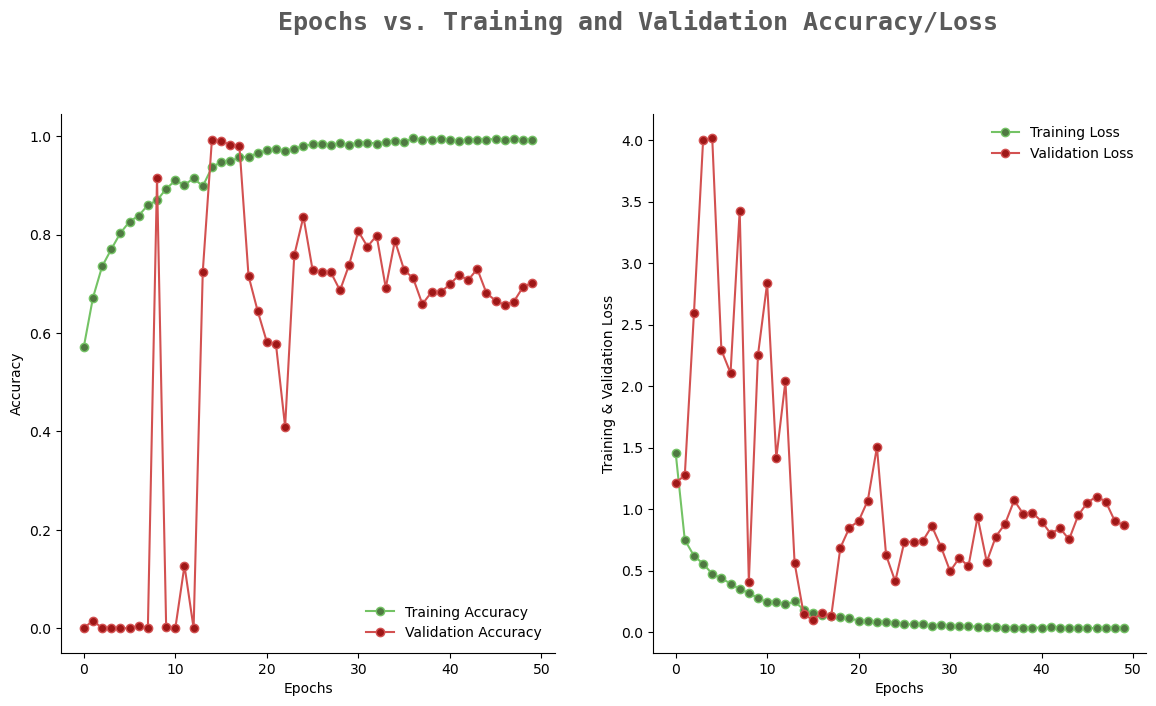

In [20]:
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs_count = [i for i in range(len(train_acc))]
fig.text(s='Epochs vs. Training and Validation Accuracy/Loss', size=18, fontweight='bold',
         fontname='monospace', color=colors_dark[1], y=1, x=0.28, alpha=0.8)

sns.despine()
ax[0].plot(epochs_count, train_acc, marker='o',markerfacecolor=colors_green[2], color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs_count, val_acc, marker='o',markerfacecolor=colors_red[2], color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
sns.despine()
ax[1].plot(epochs_count, train_loss, marker='o', markerfacecolor=colors_green[2], color=colors_green[3],
           label='Training Loss')
ax[1].plot(epochs_count, val_loss, marker='o', markerfacecolor=colors_red[2], color=colors_red[3],
           label='Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [2]:
pred_prob = model.predict(test_img_gray)
pred = np.argmax(pred_prob,axis=1)
y_test_new = np.argmax(y_test.to_numpy(),axis=1)

NameError: name 'model' is not defined

In [25]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.50      0.01      0.02       100
           1       0.59      0.11      0.19       115
           2       0.42      0.17      0.24       105
           3       0.21      0.95      0.35        74

    accuracy                           0.26       394
   macro avg       0.43      0.31      0.20       394
weighted avg       0.45      0.26      0.19       394



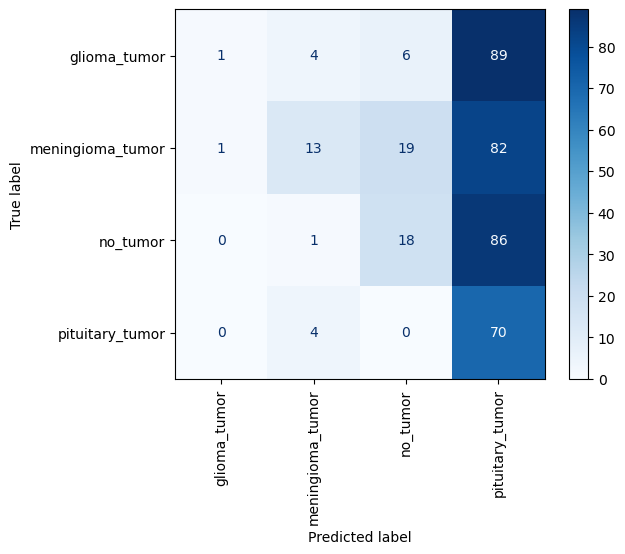

In [26]:
ConfusionMatrixDisplay.from_predictions(y_test_new, pred, display_labels=labels, 
                                        cmap='Blues', xticks_rotation="vertical")

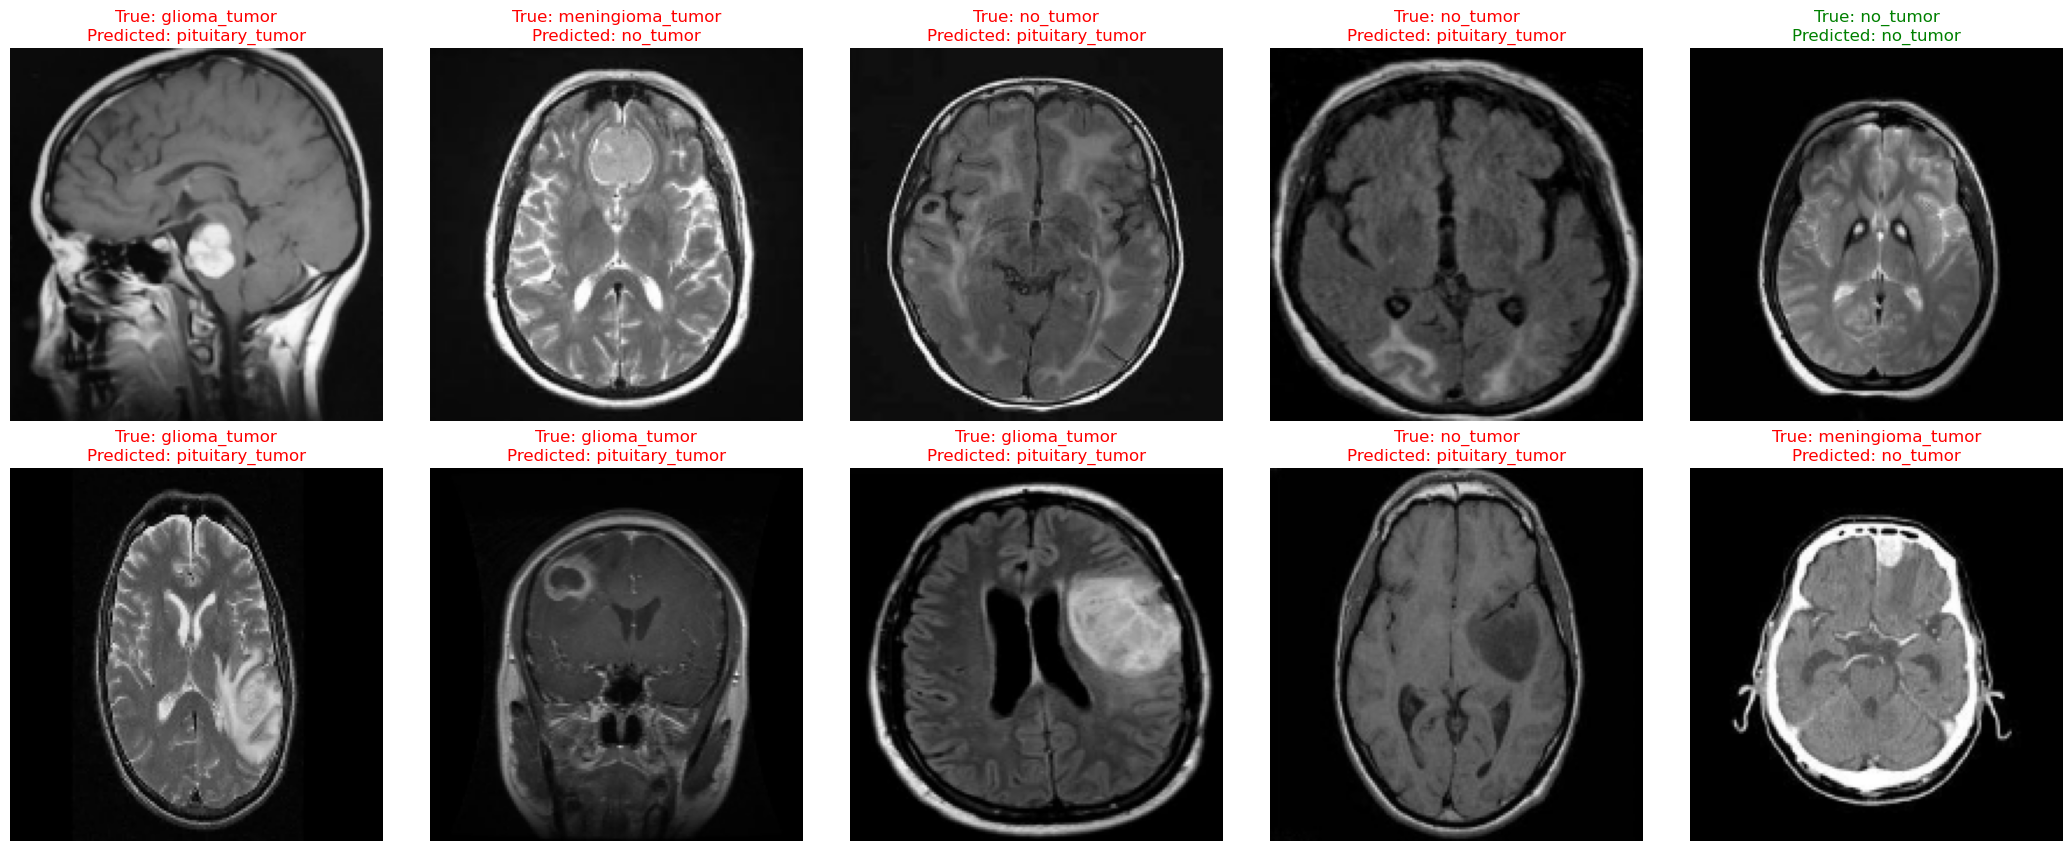

In [27]:
fig,ax_list = get_fig_and_axes_list(10,5)
random_image_index = np.random.randint(test_img.shape[0], size=10)
for count, ele in enumerate(random_image_index):
    ax_list[count]
    ax_list[count].imshow(test_img[ele])
    color = ("green" if pred[ele] == y_test_new[ele] else "red")
    ax_list[count].set_title(f"True: {test_labels_not_encoded[ele]}\nPredicted: { labels[pred[ele]] }", color=color)
    ax_list[count].axis('off')

In [28]:
model.save('saved_model')
with open('trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history, file_pi)
with open('predictions.pkl', 'wb') as file_pred:
    pickle.dump(pred, file_pred)  

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\average_pooling2d
......vars
...layers\average_pooling2d_1
......vars
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_2
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_3
......vars
.........0
.........1
.........2
.........3
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\conv2d_2
......vars
.........0
.........1
...layers\conv2d_3
......vars
.........0
.........1
...layers\conv2d_4
......vars
.........0
.........1
...layers\conv2d_5
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\flatten
......vars
...layers\max_pooling2d
......vars
...layers\rescaling
......vars
...